# Imports

In [1]:
import matplotlib.pyplot as plt
import torchvision.datasets as dset
import pickle
import numpy as np
from PIL import Image, ImageOps
import torch
from mpl_toolkits.axes_grid1 import make_axes_locatable
import math
from scipy.spatial import distance
from sklearn.metrics.pairwise import manhattan_distances

# Loading Datasets

In [2]:
# save and load data from pickel
def save_obj(obj, name ):
    with open(name, 'wb') as handle:
        pickle.dump(obj, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
def load_obj_real(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

## Generated Dataset

### Load Preporcessed Dataset

In [3]:
# loading images
images_real = load_obj_real("cifar_32_32")
images_alt_bic = load_obj_real("SN_alternate_bicubic_cifar_32_32")
images_alt_bil = load_obj_real("SN_alternate_bilinear_cifar_32_32")
images_bic = load_obj_real("SN_own_bicbuic_cifar_32_32")
images_bil = load_obj_real("SN_own_bilinear_cifar_32_32")
images_trans = load_obj_real("trans_cifar_32_32")

Real Images: 49996
Trans Images: 39936
SN Images: 39936
DC Images: 39936
FID Images: 39936
FID Images: 10000


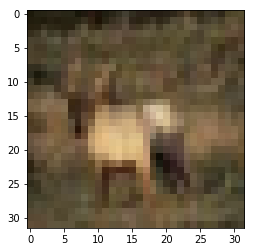

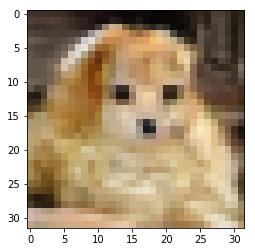

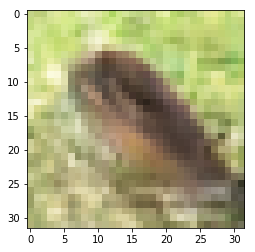

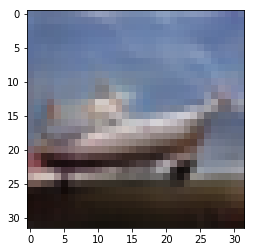

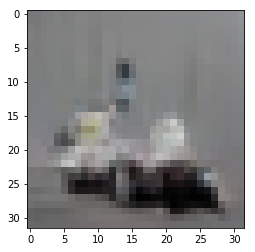

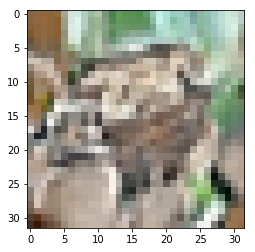

In [6]:
# Example image
print("Real Images:", len(images_real))
print("Trans Images:", len(images_alt_bic))
print("SN Images:", len(images_alt_bil))
print("DC Images:", len(images_bic))
print("FID Images:", len(images_bil))
print("FID Images:", len(images_trans))
imgplot = plt.imshow(images_real[3])
plt.show()
imgplot = plt.imshow(images_alt_bic[3])
plt.show()
imgplot = plt.imshow(images_alt_bil[3])
plt.show()
imgplot = plt.imshow(images_bic[3])
plt.show()
imgplot = plt.imshow(images_bil[3])
plt.show()
imgplot = plt.imshow(images_trans[3])
plt.show()

## Real Images

# Analyzing Images

## Creating FFT

In [4]:
def fft(img):
    img = np.array(img)
    img_g = 0.299 * img[:,:,0] + 0.587 * img[:,:,1] + 0.114 * img[:,:,2]
    #plt.imshow(img_g,cmap='gray')
    fft = np.fft.fft2(img_g)
    fshift = np.fft.fftshift(fft)
    magnitude_spectrum = 20*np.log(np.abs(fshift))
    return magnitude_spectrum

# Create Informations
def create_informations(images, normalized= False):
    two_dim = fft(images[0])
    if normalized:
        two_dim = two_dim /two_dim.max()
    m,n = two_dim.shape
    zero_axis = np.sum(two_dim, axis=0)/m
    one_axis = np.sum(two_dim, axis=1)/n
    min_zero_axis = zero_axis
    max_zero_axis = zero_axis
    min_one_axis = one_axis
    max_one_axis = one_axis
    for i in range(1,len(images)):
        fft_vals = fft(images[i])
        if normalized:
            fft_vals = fft_vals /fft_vals.max()
        two_dim = two_dim + fft_vals
        cur_zero_axis = np.sum(fft_vals, axis=0)/m
        zero_axis = zero_axis + cur_zero_axis
        cur_one_axis = np.sum(fft_vals, axis=1)/n
        one_axis = one_axis + cur_one_axis
        min_zero_axis = np.minimum(min_zero_axis, cur_zero_axis)
        max_zero_axis = np.maximum(max_zero_axis, cur_zero_axis)
        min_one_axis = np.minimum(min_one_axis, cur_one_axis)
        max_one_axis = np.maximum(max_one_axis, cur_one_axis)
    two_dim = two_dim/len(images)
    zero_axis = zero_axis/ len(images)
    one_axis = one_axis/ len(images)
    std_zero_axis = ((np.sum(two_dim, axis=0)/m)-zero_axis)**2
    std_one_axis = ((np.sum(two_dim, axis=1)/m)-one_axis)**2
    for i in range(1,len(images)):
        fft_vals = fft(images[i])
        if normalized:
            fft_vals = fft_vals/fft_vals.max()
        std_zero_axis = std_zero_axis + ((np.sum(fft_vals, axis=0)/m)-zero_axis)**2
        std_one_axis = std_one_axis + ((np.sum(fft_vals, axis=1)/m)-zero_axis)**2
    std_zero_axis = np.sqrt(std_zero_axis/len(images))
    std_one_axis = np.sqrt(std_one_axis/len(images))
    return two_dim, zero_axis, one_axis, m, n, min_zero_axis, max_zero_axis, min_one_axis, max_one_axis, std_zero_axis, std_one_axis

# Create Overview Plot
def create_overview_plot(two_dim, zero_axis, one_axis, m, n,min_zero_axis, max_zero_axis, min_one_axis, max_one_axis, std_zero_axis, std_one_axis, max_min = True):
    # Create
    fig = plt.figure(figsize=(17, 17)) 
    ax1 = plt.subplot2grid((17, 17), (1, 1), colspan=8,rowspan=8)
    ax1.plot(zero_axis)
    ax1.fill_between(range(m), zero_axis + std_zero_axis, zero_axis -std_zero_axis,facecolor='lightskyblue', alpha=0.3)
    ax2 = plt.subplot2grid((17, 17), (9, 1), colspan=8,rowspan=8)
    im3 = ax2.imshow(two_dim)
    ax3 = plt.subplot2grid((17, 17), (9, 9), colspan=8,rowspan=8)
    ax3.plot(one_axis,range(n))
    ax3.fill_betweenx(range(n),one_axis+std_one_axis, one_axis-std_one_axis, facecolor='lightskyblue', alpha=0.3)
    ax4 = plt.subplot2grid((17,17),(9,0),colspan=1,rowspan=8)

    fig.colorbar(im3, ax=ax4,fraction=0.5,ticklocation='left')
    box2 = ax2.get_position()
    box2 = [box2.x0 + 0.01, box2.y0,  box2.width+0.002, box2.height] 
    ax2.set_position(box2)
    box1 = ax1.get_position()
    box1 = [box1.x0, box1.y0-0.007,  box1.width +0.022, box1.height-0.007] 
    ax1.set_position(box1)
    box3 = ax3.get_position()
    box3 = [box3.x0, box3.y0-0.016,  box3.width, box3.height+0.032] 
    ax3.set_position(box3)
    if max_min:
        ax3.plot(min_one_axis, range(n), linestyle='dashed', color='lightskyblue')
        ax3.plot(max_one_axis, range(n), linestyle='dashed', color='lightskyblue')
        ax1.plot(range(m),min_zero_axis, linestyle='dashed', color='lightskyblue')
        ax1.plot(range(m),max_zero_axis, linestyle='dashed', color='lightskyblue')
    ax2.spines["right"].set_visible(False)
    ax2.spines["top"].set_visible(False)
    ax2.spines["left"].set_visible(False)
    ax1.spines["right"].set_visible(False)
    ax1.spines["top"].set_visible(False)
    ax3.spines["right"].set_visible(False)
    ax3.spines["top"].set_visible(False)
    ax3.axes.get_yaxis().set_visible(False)
    ax1.axes.get_xaxis().set_visible(False)
    ax4.axis('off')
    ax2.axis('off')
    plt.show()
    
def create_comparison_plot(m_1,n_1, m_2,n_2,two_dim_1, zero_axis_1, one_axis_1,
                           two_dim_2, zero_axis_2, one_axis_2, name_1="One_Image", name_2="Two_Image"):
    if m_1 == m_2 and n_1 == n_2:
        create_overview_plot(two_dim_1-two_dim_2,zero_axis_1-zero_axis_2,one_axis_1-one_axis_2,m_1,n_1,0,0,0,0,0,0,False)
    else:
        print("The dimensions are not the same!")

def create_comparison_plot_rel(m_1,n_1, m_2,n_2,two_dim_1, zero_axis_1, one_axis_1,
                           two_dim_2, zero_axis_2, one_axis_2, name_1="One_Image", name_2="Two_Image"):
    if m_1 == m_2 and n_1 == n_2:
        create_overview_plot((two_dim_1-two_dim_2)/two_dim_1,(zero_axis_1-zero_axis_2)/zero_axis_1,(one_axis_1-one_axis_2)/one_axis_1,m_1,n_1,0,0,0,0,0,0, False)
    else:
        print("The dimensions are not the same!")

Text(0.5, 0.98, 'Comparison between Real, TransGAN, SNGAN (Alt, Bilinear, Bicubic) - left: colomn wise right: row-wise')

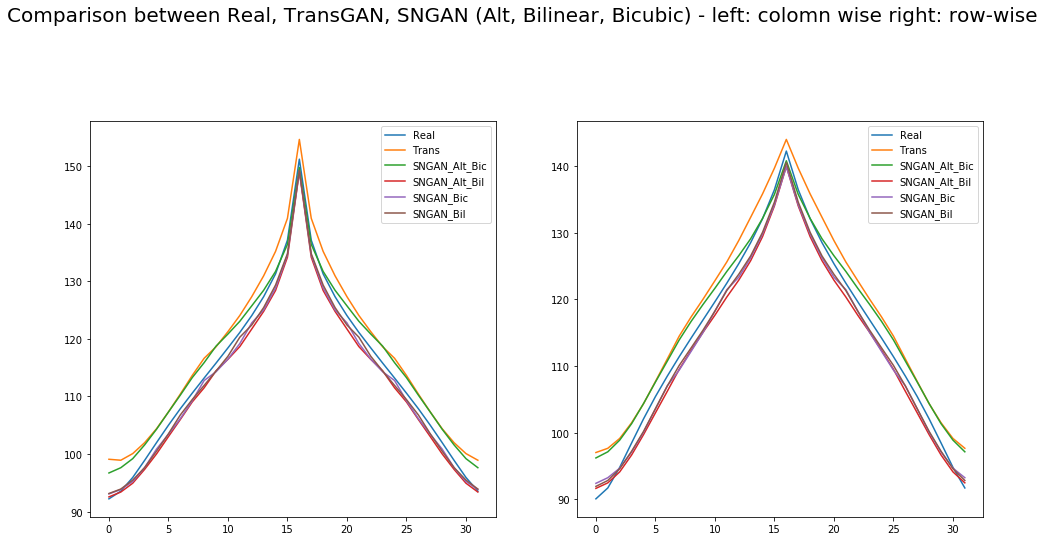

In [5]:
two_dim_r, zero_axis_r, one_axis_r, m_r, n_r,min_zero_axis_r,max_zero_axis_r, min_one_axis_r, max_one_axis_r, std_zero_axis_r, std_one_axis_r = create_informations(images_real)
two_dim_t, zero_axis_t, one_axis_t, m_t, n_t,min_zero_axis_t,max_zero_axis_t, min_one_axis_t, max_one_axis_t, std_zero_axis_t, std_one_axis_t = create_informations(images_trans)
two_dim_abic, zero_axis_abic, one_axis_abic, m_abic, n_abic,min_zero_axis_abic,max_zero_axis_abic, min_one_axis_abic, max_one_axis_abic, std_zero_axis_abic, std_one_axis_abic = create_informations(images_alt_bic)
two_dim_abil, zero_axis_abil, one_axis_abil, m_abil, n_abil,min_zero_axis_abil,max_zero_axis_abil, min_one_axis_abil, max_one_axis_abil, std_zero_axis_abil, std_one_axis_abil = create_informations(images_alt_bil)
two_dim_bic, zero_axis_bic, one_axis_bic, m_bic, n_bic,min_zero_axis_bic,max_zero_axis_bic, min_one_axis_bic, max_one_axis_bic, std_zero_axis_bic, std_one_axis_bic = create_informations(images_bic)
two_dim_bil, zero_axis_bil, one_axis_bil, m_bil, n_bil,min_zero_axis_bil,max_zero_axis_bil, min_one_axis_bil, max_one_axis_bil, std_zero_axis_bil, std_one_axis_bil = create_informations(images_bil)


fig = plt.figure(figsize=(16, 16))
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax1.plot(range(len(zero_axis_r)),zero_axis_r, label='Real')
ax1.plot(range(len(zero_axis_t)),zero_axis_t, label='Trans')
ax1.plot(range(len(zero_axis_abic)),zero_axis_abic, label='SNGAN_Alt_Bic')
ax1.plot(range(len(zero_axis_abil)),zero_axis_abil, label='SNGAN_Alt_Bil')
ax1.plot(range(len(zero_axis_bic)),zero_axis_bic, label='SNGAN_Bic')
ax1.plot(range(len(zero_axis_bil)),zero_axis_bil, label='SNGAN_Bil')

ax2.plot(range(len(one_axis_r)),one_axis_r, label='Real')
ax2.plot(range(len(one_axis_t)),one_axis_t, label='Trans')
ax2.plot(range(len(one_axis_abic)),one_axis_abic, label='SNGAN_Alt_Bic')
ax2.plot(range(len(one_axis_abil)),one_axis_abil, label='SNGAN_Alt_Bil')
ax2.plot(range(len(one_axis_bic)),one_axis_bic, label='SNGAN_Bic')
ax2.plot(range(len(one_axis_bil)),one_axis_bil, label='SNGAN_Bil')

leg = ax1.legend()
leg = ax2.legend()
fig.suptitle("Comparison between Real, TransGAN, SNGAN (Alt, Bilinear, Bicubic) - left: colomn wise right: row-wise", fontsize=20)

Text(0.5, 0.98, 'Comparison between Real, TransGAN, SNGAN (Alt, Bilinear, Bicubic) - left: colomn wise right: row-wise')

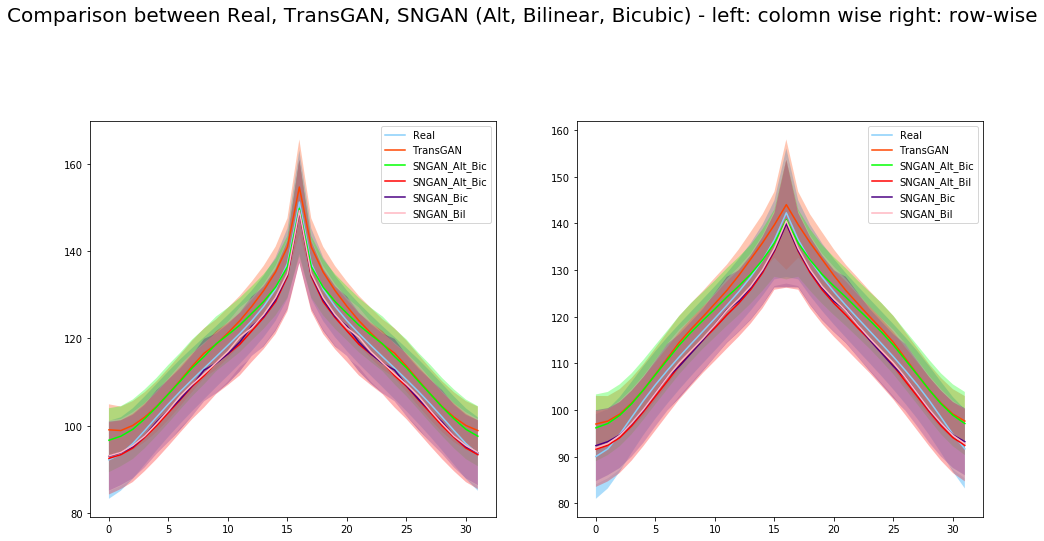

In [9]:
fig = plt.figure(figsize=(16, 16))
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax1.plot(range(len(zero_axis_r)),zero_axis_r, label='Real', color ='lightskyblue')
ax1.fill_between(range(m_r), zero_axis_r + std_zero_axis_r, zero_axis_r -std_zero_axis_r,facecolor='lightskyblue', alpha=0.7)
ax1.plot(range(len(zero_axis_t)),zero_axis_t, label='TransGAN', color ='orangered')
ax1.fill_between(range(m_t), zero_axis_t + std_zero_axis_t, zero_axis_t -std_zero_axis_t,facecolor='orangered', alpha=0.3)
ax1.plot(range(len(zero_axis_abic)),zero_axis_abic, label='SNGAN_Alt_Bic', color ='lime')
ax1.fill_between(range(m_abic), zero_axis_abic + std_zero_axis_abic, zero_axis_abic -std_zero_axis_abic,facecolor='lime', alpha=0.3)
ax1.plot(range(len(zero_axis_abil)),zero_axis_abil, label='SNGAN_Alt_Bic', color ='red')
ax1.fill_between(range(m_abil), zero_axis_abil + std_zero_axis_abil, zero_axis_abil -std_zero_axis_abil,facecolor='red', alpha=0.3)
ax1.plot(range(len(zero_axis_bic)),zero_axis_bic, label='SNGAN_Bic', color ='indigo')
ax1.fill_between(range(m_bic), zero_axis_bic+ std_zero_axis_bic, zero_axis_bic -std_zero_axis_bic,facecolor='indigo', alpha=0.3)
ax1.plot(range(len(zero_axis_bil)),zero_axis_bil, label='SNGAN_Bil', color ='lightpink')
ax1.fill_between(range(m_bil), zero_axis_bil+ std_zero_axis_bil, zero_axis_bil -std_zero_axis_bil,facecolor='lightpink', alpha=0.3)

ax2.plot(range(len(one_axis_r)),one_axis_r, label='Real', color = 'lightskyblue')
ax2.fill_between(range(m_r), one_axis_r + std_one_axis_r, one_axis_r -std_one_axis_r,facecolor='lightskyblue', alpha=0.7)
ax2.plot(range(len(one_axis_t)),one_axis_t, label='TransGAN',color = 'orangered')
ax2.fill_between(range(m_t), one_axis_t + std_one_axis_t, one_axis_t -std_one_axis_t,facecolor='orangered', alpha=0.3)
ax2.plot(range(len(one_axis_abic)),one_axis_abic, label='SNGAN_Alt_Bic',color = 'lime')
ax2.fill_between(range(m_abic), one_axis_abic + std_one_axis_abic, one_axis_abic -std_one_axis_abic,facecolor='lime', alpha=0.3)
ax2.plot(range(len(one_axis_abil)),one_axis_abil, label='SNGAN_Alt_Bil',color = 'red')
ax2.fill_between(range(m_abil), one_axis_abil + std_one_axis_abil, one_axis_abil -std_one_axis_abil,facecolor='red', alpha=0.3)
ax2.plot(range(len(one_axis_bic)),one_axis_bic, label='SNGAN_Bic',color = 'indigo')
ax2.fill_between(range(m_bic), one_axis_bic + std_one_axis_bic, one_axis_bic -std_one_axis_bic,facecolor='indigo', alpha=0.3)
ax2.plot(range(len(one_axis_bil)),one_axis_bil, label='SNGAN_Bil',color = 'lightpink')
ax2.fill_between(range(m_bil), one_axis_bil + std_one_axis_bil, one_axis_bil -std_one_axis_bil,facecolor='lightpink', alpha=0.3)

leg = ax1.legend()
leg = ax2.legend()
fig.suptitle("Comparison between Real, TransGAN, SNGAN (Alt, Bilinear, Bicubic) - left: colomn wise right: row-wise", fontsize=20)

In [10]:
def kl_divergence(p, q):
    return np.sum(np.where(p != 0, p * np.log(p / q), 0))

In [12]:
print("KL-Divergence (column):")
print("Trans:", kl_divergence(zero_axis_r,zero_axis_t))
print("SNGAN_Alt_Bic:", kl_divergence(zero_axis_r,zero_axis_abic))
print("SNGAN_Alt_Bil:", kl_divergence(zero_axis_r,zero_axis_abil))
print("SNGAN_Bic:", kl_divergence(zero_axis_r,zero_axis_bic))
print("SNGAN_Bil:", kl_divergence(zero_axis_r,zero_axis_bil))
print()
print("KL-Divergence (row):")
print("Trans:", kl_divergence(one_axis_r,one_axis_t))
print("SNGAN_Alt_Bic:", kl_divergence(one_axis_r,one_axis_abic))
print("SNGAN_Alt_Bil:", kl_divergence(one_axis_r,one_axis_abil))
print("SNGAN_Bic:", kl_divergence(one_axis_r,one_axis_bic))
print("SNGAN_Bil:", kl_divergence(one_axis_r,one_axis_bil))
print()
print("KL-Divergence (col vs row):")
print("Real:", kl_divergence(zero_axis_r,one_axis_r))
print("Trans:", kl_divergence(zero_axis_t,one_axis_t))
print("SNGAN_Alt_Bic:", kl_divergence(zero_axis_abic,one_axis_abic))
print("SNGAN_Alt_Bil:", kl_divergence(zero_axis_abil,one_axis_abil))
print("SNGAN_Bic:", kl_divergence(zero_axis_bic,one_axis_bic))
print("SNGAN_Bil:", kl_divergence(zero_axis_bil,one_axis_bil))

KL-Divergence (column):
Trans: -107.6728584159312
SNGAN_Alt_Bic: -66.49159544303028
SNGAN_Alt_Bil: 58.89308264524164
SNGAN_Bic: 45.101123936245145
SNGAN_Bil: 39.84207936430141

KL-Divergence (row):
Trans: -107.60311041072691
SNGAN_Alt_Bic: -66.28388462138165
SNGAN_Alt_Bil: 58.96865810866815
SNGAN_Bic: 45.21163414348601
SNGAN_Bil: 39.903590926708745

KL-Divergence (col vs row):
Real: 0.44492513349616836
Trans: 0.5499598724643464
SNGAN_Alt_Bic: 0.3288105408551685
SNGAN_Alt_Bil: 0.39086058012491076
SNGAN_Bic: 0.4236519182564633
SNGAN_Bil: 0.36552182258532895


In [13]:
print("Manhattan distance (column):")
print("Trans:", manhattan_distances([zero_axis_r],[zero_axis_t])[0][0])
print("SNGAN_Alt_Bic:", manhattan_distances([zero_axis_r],[zero_axis_abic])[0][0])
print("SNGAN_Alt_Bil:", manhattan_distances([zero_axis_r],[zero_axis_abil])[0][0])
print("SNGAN_Bic:", manhattan_distances([zero_axis_r],[zero_axis_bic])[0][0])
print("SNGAN_Bil:", manhattan_distances([zero_axis_r],[zero_axis_bil])[0][0])
print()
print("Manhattan distance (row):")
print("Trans:", manhattan_distances([one_axis_r],[one_axis_t])[0][0])
print("SNGAN_Alt_Bic:", manhattan_distances([one_axis_r],[one_axis_abic])[0][0])
print("SNGAN_Alt_Bil:", manhattan_distances([one_axis_r],[one_axis_abil])[0][0])
print("SNGAN_Bic:", manhattan_distances([one_axis_r],[one_axis_bic])[0][0])
print("SNGAN_Bil:", manhattan_distances([one_axis_r],[one_axis_bil])[0][0])
print()
print("Manhattan distance (col vs row):")
print("Real:", manhattan_distances([zero_axis_r],[one_axis_r])[0][0])
print("Trans:", manhattan_distances([zero_axis_t],[one_axis_t])[0][0])
print("SNGAN_Alt_Bic:", manhattan_distances([zero_axis_abic],[one_axis_abic])[0][0])
print("SNGAN_Alt_Bil:", manhattan_distances([zero_axis_abil],[one_axis_abil])[0][0])
print("SNGAN_Bic:", manhattan_distances([zero_axis_bic],[one_axis_bic])[0][0])
print("SNGAN_Bil:", manhattan_distances([zero_axis_bil],[one_axis_bil])[0][0])

Manhattan distance (column):
Trans: 109.48088108041823
SNGAN_Alt_Bic: 73.24083568695693
SNGAN_Alt_Bil: 59.03220946285889
SNGAN_Bic: 47.63396804164407
SNGAN_Bil: 42.88826399305357

Manhattan distance (row):
Trans: 109.48088108043288
SNGAN_Alt_Bic: 73.13951487793699
SNGAN_Alt_Bil: 64.56281367907837
SNGAN_Bic: 55.54975030243476
SNGAN_Bil: 47.784663800745705

Manhattan distance (col vs row):
Real: 38.956706323938135
Trans: 41.7490913441941
SNGAN_Alt_Bic: 26.077930005358724
SNGAN_Alt_Bil: 32.30109524628297
SNGAN_Bic: 33.98591529102187
SNGAN_Bil: 31.917897694059334


In [15]:
print("Euclidean distance (column):")
print("Trans:", np.linalg.norm(zero_axis_r-zero_axis_t))
print("SNGAN_Alt_Bic:", np.linalg.norm(zero_axis_r-zero_axis_abic))
print("SNGAN_Alt_Bil:", np.linalg.norm(zero_axis_r-zero_axis_abil))
print("SNGAN_Bic:", np.linalg.norm(zero_axis_r-zero_axis_bic))
print("SNGAN_Bil:", np.linalg.norm(zero_axis_r-zero_axis_bil))
print()
print("Euclidean distance (row):")
print("Trans:", np.linalg.norm(one_axis_r-one_axis_t))
print("SNGAN_Alt_Bic:", np.linalg.norm(one_axis_r-one_axis_abic))
print("SNGAN_Alt_Bil:", np.linalg.norm(one_axis_r-one_axis_abil))
print("SNGAN_Bic:", np.linalg.norm(one_axis_r-one_axis_bic))
print("SNGAN_Bil:", np.linalg.norm(one_axis_r-one_axis_bil))
print()
print("Euclidean distance (col vs row):")
print("Real:", np.linalg.norm(zero_axis_r-one_axis_r))
print("Trans:", np.linalg.norm(zero_axis_t-one_axis_t))
print("SNGAN_Alt_Bic:", np.linalg.norm(zero_axis_abic-one_axis_abic))
print("SNGAN_Alt_Bil:", np.linalg.norm(zero_axis_abil-one_axis_abil))
print("SNGAN_Bic:", np.linalg.norm(zero_axis_bic-one_axis_bic))
print("SNGAN_Bil:", np.linalg.norm(zero_axis_bil-one_axis_bil))

Euclidean distance (column):
Trans: 20.110179218008774
SNGAN_Alt_Bic: 14.100492807324535
SNGAN_Alt_Bil: 11.239652587500707
SNGAN_Bic: 9.209892293455118
SNGAN_Bil: 8.119803258245625

Euclidean distance (row):
Trans: 20.315857423841656
SNGAN_Alt_Bic: 15.28867917439228
SNGAN_Alt_Bil: 11.867739946284786
SNGAN_Bic: 10.326051586052818
SNGAN_Bil: 8.808527954288202

Euclidean distance (col vs row):
Real: 10.796220688325816
Trans: 12.337062520714241
SNGAN_Alt_Bic: 9.601314431242724
SNGAN_Alt_Bil: 10.28048199575902
SNGAN_Bic: 10.699226429314738
SNGAN_Bil: 9.923619740983193


## Normalized

Text(0.5, 0.98, 'Comparison between Real, TransGAN, SNGAN(Alt, Bilinear, Bicubic) (Normalized) - left: colomn wise right: row-wise')

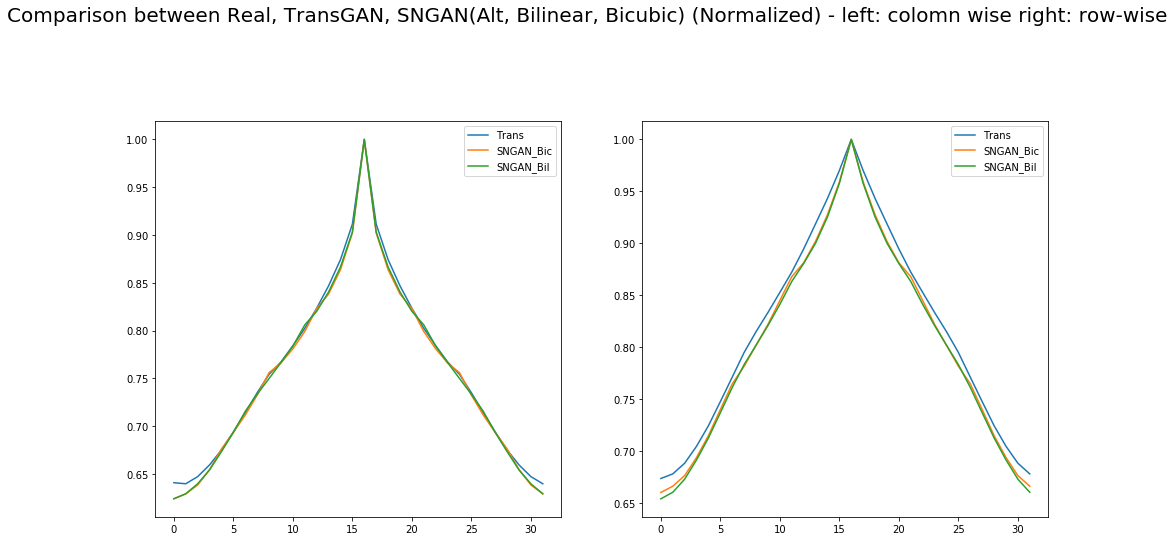

In [8]:
fig = plt.figure(figsize=(16, 16))
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
#ax1.plot(range(len(zero_axis_r)),zero_axis_r/zero_axis_r.max(), label='Real')
ax1.plot(range(len(zero_axis_t)),zero_axis_t/zero_axis_t.max(), label='Trans')
#ax1.plot(range(len(zero_axis_abic)),zero_axis_abic/zero_axis_abic.max(), label='SNGAN_Alt_Bic')
#ax1.plot(range(len(zero_axis_abil)),zero_axis_abil/zero_axis_abil.max(), label='SNGAN_Alt_Bil')
ax1.plot(range(len(zero_axis_bic)),zero_axis_bic/zero_axis_bic.max(), label='SNGAN_Bic')
ax1.plot(range(len(zero_axis_bil)),zero_axis_bil/zero_axis_bil.max(), label='SNGAN_Bil')

#ax2.plot(range(len(one_axis_r)),one_axis_r/one_axis_r.max(), label='Real')
ax2.plot(range(len(one_axis_t)),one_axis_t/one_axis_t.max(), label='Trans')
#ax2.plot(range(len(one_axis_abic)),one_axis_abic/one_axis_abic.max(), label='SNGAN_Alt_Bic')
#ax2.plot(range(len(one_axis_abic)),one_axis_abil/one_axis_abil.max(), label='SNGAN_Alt_Bil')
ax2.plot(range(len(one_axis_bic)),one_axis_bic/one_axis_bic.max(), label='SNGAN_Bic')
ax2.plot(range(len(one_axis_bil)),one_axis_bil/one_axis_bil.max(), label='SNGAN_Bil')

leg = ax1.legend()
leg = ax2.legend()
fig.suptitle("Comparison between Real, TransGAN, SNGAN(Alt, Bilinear, Bicubic) (Normalized) - left: colomn wise right: row-wise", fontsize=20)

In [18]:
print("KL-Divergence (column):")
print("Trans:", kl_divergence(zero_axis_r/zero_axis_r.max(),zero_axis_t/zero_axis_t.max()))
print("SNGAN_Alt_Bic:", kl_divergence(zero_axis_r/zero_axis_r.max(),zero_axis_abic/zero_axis_abic.max()))
print("SNGAN_Alt_Bil:", kl_divergence(zero_axis_r/zero_axis_r.max(),zero_axis_abil/zero_axis_abil.max()))
print("SNGAN_Bic:", kl_divergence(zero_axis_r/zero_axis_r.max(),zero_axis_bic/zero_axis_bic.max()))
print("SNGAN_Bil:", kl_divergence(zero_axis_r/zero_axis_r.max(),zero_axis_bil/zero_axis_bil.max()))
print()
print("KL-Divergence (row):")
print("Trans:", kl_divergence(one_axis_r/one_axis_r.max(),one_axis_t/one_axis_t.max()))
print("SNGAN_Alt_Bic:", kl_divergence(one_axis_r/one_axis_r.max(),one_axis_abic/one_axis_abic.max()))
print("SNGAN_Alt_Bil:", kl_divergence(one_axis_r/one_axis_r.max(),one_axis_abil/one_axis_abil.max()))
print("SNGAN_Bic:", kl_divergence(one_axis_r/one_axis_r.max(),one_axis_bic/one_axis_bic.max()))
print("SNGAN_Bil:", kl_divergence(one_axis_r/one_axis_r.max(),one_axis_bil/one_axis_bil.max()))

KL-Divergence (column):
Trans: -0.17075431997645224
SNGAN_Alt_Bic: -0.6719670118187293
SNGAN_Alt_Bil: 0.03964728256252996
SNGAN_Bic: -0.028540483359408765
SNGAN_Bil: -0.04964373628903479

KL-Divergence (row):
Trans: -0.4433399946086024
SNGAN_Alt_Bic: -0.7301459465713238
SNGAN_Alt_Bil: -0.004073240705279115
SNGAN_Bic: -0.1039912681367898
SNGAN_Bil: -0.030282240794954868


In [19]:
print("Manhattan distance (column):")
print("Trans:", manhattan_distances([zero_axis_r/zero_axis_r.max()],[zero_axis_t/zero_axis_t.max()])[0][0])
print("SNGAN_Alt_Bic:", manhattan_distances([zero_axis_r/zero_axis_r.max()],[zero_axis_abic/zero_axis_abic.max()])[0][0])
print("SNGAN_Alt_Bil:", manhattan_distances([zero_axis_r/zero_axis_r.max()],[zero_axis_abil/zero_axis_abil.max()])[0][0])
print("SNGAN_Bic:", manhattan_distances([zero_axis_r/zero_axis_r.max()],[zero_axis_bic/zero_axis_bic.max()])[0][0])
print("SNGAN_Bil:", manhattan_distances([zero_axis_r/zero_axis_r.max()],[zero_axis_bil/zero_axis_bil.max()])[0][0])
print()
print("Manhattan distance (row):")
print("Trans:", manhattan_distances([one_axis_r/one_axis_r.max()],[one_axis_t/one_axis_t.max()])[0][0])
print("SNGAN_Alt_Bic:", manhattan_distances([one_axis_r/one_axis_r.max()],[one_axis_abic/one_axis_abic.max()])[0][0])
print("SNGAN_Alt_Bil:", manhattan_distances([one_axis_r/one_axis_r.max()],[one_axis_abil/one_axis_abil.max()])[0][0])
print("SNGAN_Bic:", manhattan_distances([one_axis_r/one_axis_r.max()],[one_axis_bic/one_axis_bic.max()])[0][0])
print("SNGAN_Bil:", manhattan_distances([one_axis_r/one_axis_r.max()],[one_axis_bil/one_axis_bil.max()])[0][0])

Manhattan distance (column):
Trans: 0.17464671619917915
SNGAN_Alt_Bic: 0.6835957815676041
SNGAN_Alt_Bil: 0.11429636468576665
SNGAN_Bic: 0.11081049180608571
SNGAN_Bil: 0.08815071509833561

Manhattan distance (row):
Trans: 0.44910493521736805
SNGAN_Alt_Bic: 0.7444632844042312
SNGAN_Alt_Bil: 0.12789516599712014
SNGAN_Bic: 0.1385353111808333
SNGAN_Bil: 0.11321420161063556


In [21]:
print("Euclidean distance (column):")
print("Trans:", np.linalg.norm(zero_axis_r/zero_axis_r.max()-zero_axis_t/zero_axis_t.max()))
print("SNGAN_Alt_Bic:", np.linalg.norm(zero_axis_r/zero_axis_r.max()-zero_axis_abic/zero_axis_abic.max()))
print("SNGAN_Alt_Bil:", np.linalg.norm(zero_axis_r/zero_axis_r.max()-zero_axis_abil/zero_axis_abil.max()))
print("SNGAN_Bic:", np.linalg.norm(zero_axis_r/zero_axis_r.max()-zero_axis_bic/zero_axis_bic.max()))
print("SNGAN_Bil:", np.linalg.norm(zero_axis_r/zero_axis_r.max()-zero_axis_bil/zero_axis_bil.max()))
print()
print("Euclidean distance (row):")
print("Trans:", np.linalg.norm(one_axis_r/one_axis_r.max()-one_axis_t/one_axis_t.max()))
print("SNGAN_Alt_Bic:", np.linalg.norm(one_axis_r/one_axis_r.max()-one_axis_abic/one_axis_abic.max()))
print("SNGAN_Alt_Bil:", np.linalg.norm(one_axis_r/one_axis_r.max()-one_axis_abil/one_axis_abil.max()))
print("SNGAN_Bic:", np.linalg.norm(one_axis_r/one_axis_r.max()-one_axis_bic/one_axis_bic.max()))
print("SNGAN_Bil:", np.linalg.norm(one_axis_r/one_axis_r.max()-one_axis_bil/one_axis_bil.max()))

Euclidean distance (column):
Trans: 0.04995985283975365
SNGAN_Alt_Bic: 0.12915169399830537
SNGAN_Alt_Bil: 0.025128764075285876
SNGAN_Bic: 0.026860380443850338
SNGAN_Bil: 0.024383545213251784

Euclidean distance (row):
Trans: 0.09183226797430347
SNGAN_Alt_Bic: 0.14569749972755985
SNGAN_Alt_Bil: 0.036032682021370596
SNGAN_Bic: 0.04537648620509906
SNGAN_Bil: 0.03425874026481745
